<a href="https://colab.research.google.com/github/gonzaq94/NER-LLM-classification/blob/main/fine_tune_BERT_doc_level_annots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import comet_ml
import comet_llm
import os
import gdown
from datasets import load_dataset
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns

# Download and augment dataset with GPT

In [32]:
# Load the CONLL dataset
dataset_train = load_dataset("conll2003", split="train").shuffle().select(range(1000))
dataset_valid = load_dataset("conll2003", split="validation").shuffle().select(range(1000))

In [79]:
dataset_test = load_dataset("conll2003", split="test")

In [58]:
client = OpenAI(api_key=OPEN_AI_API_KEY)

# Function to classify a document
def classify_document(document_text):

    prompt = f"""
    You are an AI document classifier. Please classify the following document into one of the following categories: World, Sport, Business, Technology, Other.

    Document:
    "{document_text}"

    Category:
    """

    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o-mini",
        max_tokens=10,  # Only need a few tokens for the category response
        temperature=0  # Lower temperature for deterministic results
    )

    return response.choices[0].message.content

# Classify some example documents

for i in range(5):

  example = " ".join(dataset_train[i]['tokens'])

  category = classify_document(example)

  print(f"Example {i}:", example)
  print("Classification:", category)
  print()


Example 0: DETROIT 46 82 .359 27 1/2
Classification: Other

Example 1: Masterkova dominated the middle-distance races at the recent Atlanta Games following her return to competition this season after a three-year maternity break .
Classification: Sport

Example 2: The area is filled with treacherous mountain peaks , ice fields and frigid waters .
Classification: Other

Example 3: " The premium will be no lower than 15 percent and will be set by management before the issue ...
Classification: Business

Example 4: DUBAI 1996-08-29
Classification: Other



## Augment all dataset with document-level annotations

In [61]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}

def add_document_label(row):

    text = " ".join(row['tokens'])
    doc_label = classify_document(text)
    row["doc_labels"] = doc_label_dct[doc_label.lstrip("Category: ")]

    return row

In [62]:
dataset_train_augmented = dataset_train.map(add_document_label)
dataset_valid_augmented = dataset_valid.map(add_document_label)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [80]:
dataset_test_augmented = dataset_test.map(add_document_label)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

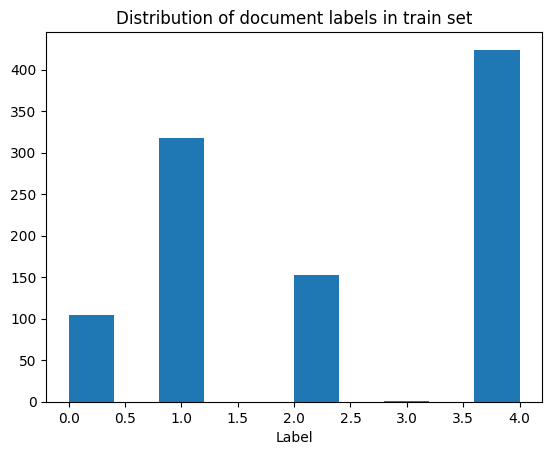

In [66]:
plt.hist(dataset_train_augmented['doc_labels'])
plt.title('Distribution of document labels in train set')
plt.xlabel('Label')
plt.show()

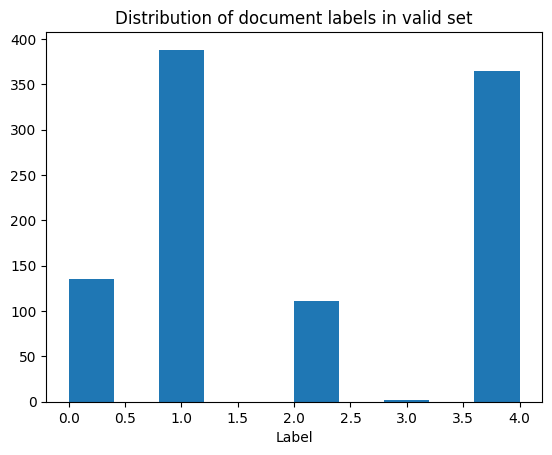

In [67]:
plt.hist(dataset_valid_augmented['doc_labels'])
plt.title('Distribution of document labels in valid set')
plt.xlabel('Label')
plt.show()

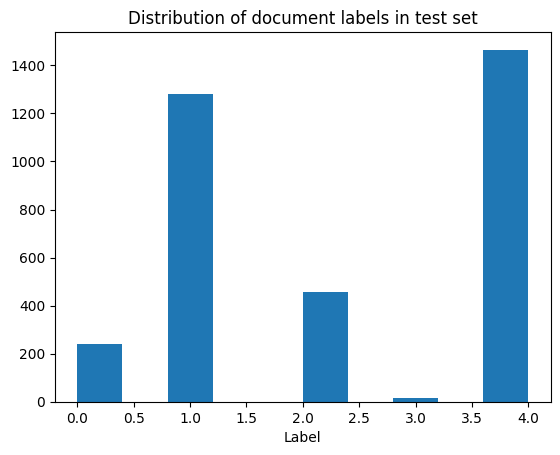

In [81]:
plt.hist(dataset_test_augmented['doc_labels'])
plt.title('Distribution of document labels in test set')
plt.xlabel('Label')
plt.show()

In [82]:
# Save the dataset to a directory
dataset_train_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k")
dataset_valid_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k")
dataset_test_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented_1k")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

In [76]:
from datasets import load_from_disk

loaded_train_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k")

In [77]:
loaded_train_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'doc_labels'],
    num_rows: 1000
})

## Prepare data

In [85]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [173]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = " ".join(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'label': label
        }


In [174]:
train_custom_dataset = CustomDataset(
    texts=dataset_train_augmented['tokens'],
    labels=dataset_train_augmented['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = CustomDataset(
    texts=dataset_valid_augmented['tokens'],
    labels=dataset_valid_augmented['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

In [175]:
for elem in train_custom_dataset:
  print(elem['label'].shape)
  break

torch.Size([])


## Fine-tune model

In [161]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_WORKSPACE"] = "gonzaq94"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-doc_level_annots"
os.environ["COMET_API_KEY"] = "70hdKpWAXsGBl956kbVxML85N"

In [162]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(doc_label_dct))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [163]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }

In [164]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    dataloader_drop_last=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    compute_metrics=compute_metrics
)


In [165]:
trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


ValueError: too many values to unpack (expected 2)

Evaluate model

In [98]:
def plot_confusion_matrix(cm, class_names):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def compute_metrics_eval(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions, normalize='true')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }


class Evaluator:
    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

In [ ]:
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(valid_custom_dataset)

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}
class_names = [k for k, v in doc_label_dct.items()]
plot_confusion_matrix(eval_results['eval_confusion_matrix'], class_names)